In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.0'

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer

MEASUREMENTS_PER_SAMPLE = 100
SAMPLE_STEP = 5
CSV_FILE_PATH = '../gyroscope_data_updated.csv'

df = pd.read_csv(CSV_FILE_PATH)

In [3]:
train_part_in_percents = 0.6
val_part_in_percents = 0.2
test_part_in_percents = 0.2

def split(samples, train_part_in_percents, val_part_in_percents, test_part_in_percents):
    train_part_end = int(train_part_in_percents * samples.shape[0])
    val_part_end = train_part_end + int(val_part_in_percents * samples.shape[0])
    test_part_end = val_part_end + int(test_part_in_percents * samples.shape[0])

    train_data = samples[0:train_part_end]
    val_data = samples[train_part_end:val_part_end]
    test_data = samples[val_part_end:test_part_end]
    
    return train_data, val_data, test_data

train_data_array = []
val_data_array = []
test_data_array = []

for label in df['activity_type'].unique():
    train_data, val_data, test_data = split(df[df['activity_type'] == label], 0.6, 0.2, 0.2)
    train_data_array.append(train_data)
    val_data_array.append(val_data)
    test_data_array.append(test_data)

train_df = pd.concat(train_data_array)
val_df = pd.concat(val_data_array)
test_df = pd.concat(test_data_array)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(45960, 7)
(15320, 7)
(15320, 7)


In [4]:
def preparaSamplesAndTargets(df):
    targets_and_samples = []

    def prepareForOneLabel(label, df):
        l_df = df[df['activity_type'] == label]
        l_df = l_df[l_df.columns[0:-1]]
        samples_number = (l_df.shape[0] - MEASUREMENTS_PER_SAMPLE) // SAMPLE_STEP
    
        def getSample(sample_index):
            sample_start_index = sample_index * SAMPLE_STEP
            sample_end_index = (sample_index * SAMPLE_STEP) + MEASUREMENTS_PER_SAMPLE
        
            return l_df[sample_start_index:sample_end_index].values.reshape(1, MEASUREMENTS_PER_SAMPLE, 6)
    
        return [[label, getSample(sample_index)] for sample_index in range(samples_number)]

    for label in df['activity_type'].unique():
        targets_and_samples.extend(prepareForOneLabel(label, df))

    samples = np.concatenate([ts[1] for ts in targets_and_samples])
    targets = LabelBinarizer().fit_transform(np.array([ts[0] for ts in targets_and_samples]))
    
    return samples, targets

train_data, train_labels = preparaSamplesAndTargets(train_df)
val_data, val_labels = preparaSamplesAndTargets(val_df)
test_data, test_labels = preparaSamplesAndTargets(test_df)

print(train_data.shape)
print(train_labels.shape)

print(val_data.shape)
print(val_labels.shape)

print(test_data.shape)
print(test_labels.shape)

(9092, 100, 6)
(9092, 5)
(2964, 100, 6)
(2964, 5)
(2964, 100, 6)
(2964, 5)


In [6]:
def shuffleSamplesAndTargets(samples, targets):
    randomize = np.arange(samples.shape[0])
    np.random.shuffle(randomize)
    samples = samples[randomize]
    targets = targets[randomize]
    
    return samples, targets

train_data, train_labels = shuffleSamplesAndTargets(train_data, train_labels)

In [14]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv1D(32, 3, activation='relu',
                        input_shape=(None, train_data.shape[-1])))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(test_labels.shape[-1], activation='softmax'))

In [15]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.0005),
              loss='mse',
              metrics=['accuracy'])

In [16]:
PATH_TO_BEST_MODEL = 'models/best_model.hdf5'

callbacks = [
    keras.callbacks.ModelCheckpoint(PATH_TO_BEST_MODEL, 
                                    monitor='val_acc', 
                                    verbose=0, 
                                    save_best_only=True, 
                                    save_weights_only=False, 
                                    mode='auto', 
                                    period=1)
]

%time history = model.fit(train_data, train_labels, epochs=100, callbacks=callbacks, batch_size=64, validation_data=(val_data, val_labels))

Train on 9092 samples, validate on 2964 samples
Epoch 1/100
9092/9092 [==============================] - 2s 188us/step - loss: 0.2649 - acc: 0.3119 - val_loss: 0.1759 - val_acc: 0.4963
Epoch 2/100
9092/9092 [==============================] - 1s 129us/step - loss: 0.1790 - acc: 0.5247 - val_loss: 0.1707 - val_acc: 0.5422
Epoch 3/100
9092/9092 [==============================] - 1s 126us/step - loss: 0.1561 - acc: 0.5815 - val_loss: 0.2092 - val_acc: 0.4291
Epoch 4/100
9092/9092 [==============================] - 1s 126us/step - loss: 0.1390 - acc: 0.6183 - val_loss: 0.1557 - val_acc: 0.5739
Epoch 5/100
9092/9092 [==============================] - 1s 126us/step - loss: 0.1211 - acc: 0.6573 - val_loss: 0.1549 - val_acc: 0.5499
Epoch 6/100
9092/9092 [==============================] - 1s 128us/step - loss: 0.1070 - acc: 0.6910 - val_loss: 0.1401 - val_acc: 0.5877
Epoch 7/100
9092/9092 [==============================] - 1s 126us/step - loss: 0.0946 - acc: 0.7127 - val_loss: 0.1183 - val_acc: 

9092/9092 [==============================] - 1s 147us/step - loss: 0.0080 - acc: 0.9762 - val_loss: 0.0838 - val_acc: 0.7615
Epoch 61/100
9092/9092 [==============================] - 1s 141us/step - loss: 0.0078 - acc: 0.9757 - val_loss: 0.0905 - val_acc: 0.7335
Epoch 62/100
9092/9092 [==============================] - 1s 139us/step - loss: 0.0079 - acc: 0.9764 - val_loss: 0.0948 - val_acc: 0.7213
Epoch 63/100
9092/9092 [==============================] - 1s 154us/step - loss: 0.0073 - acc: 0.9773 - val_loss: 0.0944 - val_acc: 0.7183
Epoch 64/100
9092/9092 [==============================] - 1s 143us/step - loss: 0.0077 - acc: 0.9771 - val_loss: 0.0877 - val_acc: 0.7409
Epoch 65/100
9092/9092 [==============================] - 1s 142us/step - loss: 0.0080 - acc: 0.9760 - val_loss: 0.0873 - val_acc: 0.7480
Epoch 66/100
9092/9092 [==============================] - 1s 142us/step - loss: 0.0074 - acc: 0.9779 - val_loss: 0.0921 - val_acc: 0.7304
Epoch 67/100
9092/9092 [=======================

              acc     val_acc        loss    val_loss
count  100.000000  100.000000  100.000000  100.000000
mean     0.930058    0.729784    0.023857    0.092446
std      0.109414    0.057658    0.040251    0.021090
min      0.311923    0.429150    0.005177    0.070422
25%      0.948004    0.726805    0.006813    0.082720
50%      0.971568    0.744771    0.009372    0.087385
75%      0.979130    0.757928    0.017356    0.092193
max      0.984712    0.780364    0.264910    0.209204


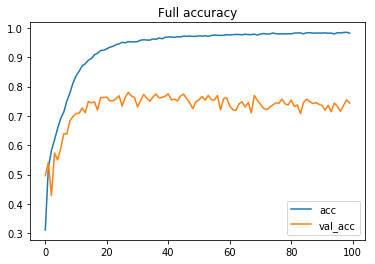

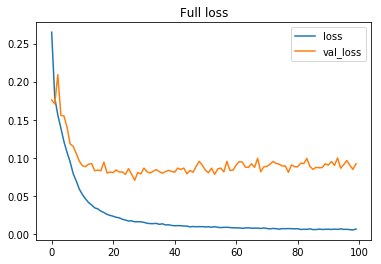

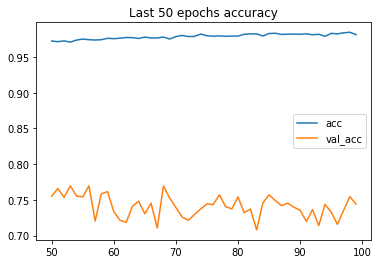

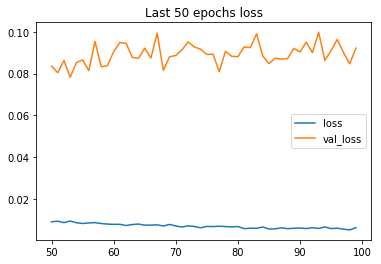

In [17]:
%matplotlib inline

history_df = pd.DataFrame(
    {'acc': history.history['acc'],
     'val_acc': history.history['val_acc'],
     'loss': history.history['loss'],
     'val_loss': history.history['val_loss']
    })

print(history_df.describe())

history_df[['acc', 'val_acc']].plot(title='Full accuracy')
history_df[['loss', 'val_loss']].plot(title='Full loss')
history_df[['acc', 'val_acc']][-50:].plot(title='Last 50 epochs accuracy')
history_df[['loss', 'val_loss']][-50:].plot(title='Last 50 epochs loss')

In [18]:
best_model = keras.models.load_model(PATH_TO_BEST_MODEL)

In [19]:
best_model.evaluate(test_data, test_labels)

2964/2964 [==============================] - 0s 62us/step


[0.14632535253972825, 0.5823211875843455]

In [20]:
best_model.predict(test_data[0:1])

array([[1.7339249e-06, 3.6546916e-02, 8.1800982e-02, 3.2796815e-02,
        8.4885359e-01]], dtype=float32)